In [1]:
from copy import deepcopy

from sqlalchemy.sql.base import elements
%pwd
%cd ../..

/Users/aflamant/Documents/courses/2024-2025/mémoire/03-code/memoire/MLP


In [2]:
# General
import numpy as np
import re
import ast
import torch
import mlflow

from concurrent.futures import ThreadPoolExecutor
from torch import nn, dtype
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.model_selection import KFold
import torchmetrics.regression as R

# Model
from MLP.loss import StiffnessToLoadLoss, construct_k_from_ea
from MLP.dataset import SeismicTwoStoriesTrussDatasetSingleTarget
from MLP.models.architecture import MultiLayerPerceptron
from MLP.models.processing import StandardScaler

# Setup randomness
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [3]:
data_path = "./data/dataset/seismic_two_stories/data.hdf5"
_ds = SeismicTwoStoriesTrussDatasetSingleTarget(data_path,
                                                noise_loads=lambda size: np.random.normal(1, 0.005, size=size),
                                                noise_strain=lambda size: np.random.normal(1, 0.005, size=size),
                                                noise_displacement=lambda size: np.random.normal(0, 5e-5, size=size))

# Reduced set of 25K for hyperparameter tuning
ds = Subset(_ds, np.random.choice(np.arange(len(_ds)), 75_000, replace=False))
train_ds, val_ds, test_ds = random_split(ds, (25_000, 25_000, 25_000))

in_dim = ds[0][0].__len__()
out_dim = ds[0][1].__len__()

print(f"Dataset size: {len(ds)}")
print(f"  Sample dimension: {in_dim}")
print(f"  Target dimension: {out_dim}")
print()
print(f"Train dataset size:\t\t\t{len(train_ds)}")
print(f"Validation dataset size:\t{len(val_ds)}")
print(f"Test dataset size:\t\t\t{len(test_ds)}")

Dataset size: 75000
  Sample dimension: 22
  Target dimension: 1

Train dataset size:			25000
Validation dataset size:	25000
Test dataset size:			25000


# Hyper parameter tuning

In [10]:
def train(model, train_ds, val_ds, lr, n_epochs, train_batch_size, verbose=True, verbose_step=50, val_batch_size=None):
    model = model.to(device)
    if val_batch_size is None:
        val_batch_size = train_batch_size
    train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=val_batch_size, shuffle=True)

    # Fit scalers
    x_scaler = StandardScaler(in_dim).to(device)
    y_scaler = StandardScaler(out_dim).to(device)
    for data, target, _, _, _ in train_dl:
        x_scaler.partial_fit(data.to(device))
        y_scaler.partial_fit(target.to(device))

    # Train
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    MSE = nn.MSELoss()
    R2 = R.R2Score().to(device)
    MAPE = R.MeanAbsolutePercentageError().to(device)

    best_val_loss = np.inf
    best_model = None
    for epoch in range(n_epochs):
        model.train()
        train_loss_epoch = []
        train_MSE_epoch = []
        train_MAPE_epoch = []
        train_R2_epoch = []

        for batch in train_dl:
            data, target, _, _, _ = batch
            data, target = data.to(device), target.to(device)

            # Normalize
            z_data = x_scaler.transform(data)
            z_target = y_scaler.transform(target)

            # Train
            optimizer.zero_grad()
            z_target_pred = model(z_data)
            loss = criterion(z_target_pred, z_target)
            loss.backward()
            optimizer.step()

            # Metrics
            target_pred = y_scaler.inverse_transform(z_target_pred)
            train_loss_epoch.append(loss.item())
            train_MSE_epoch.append(MSE(target_pred, target).item())
            train_MAPE_epoch.append(MAPE(target_pred, target).item())
            train_R2_epoch.append(R2(target_pred, target))

        model.eval()
        with torch.no_grad():
            val_loss_epoch = []
            val_MSE_epoch = []
            val_MAPE_epoch = []
            val_R2_epoch = []
            for batch in val_dl:
                data, target, _, _, _ = batch
                data, target = data.to(device), target.to(device)

                # Normalize
                z_data = x_scaler.transform(data)
                z_target = y_scaler.transform(target)

                # Metrics
                z_target_pred = model(z_data)
                loss = criterion(z_target_pred, z_target)

                target_pred = y_scaler.inverse_transform(z_target_pred)
                val_loss_epoch.append(loss.item())
                val_MSE_epoch.append(MSE(target_pred, target).item())
                val_MAPE_epoch.append(MAPE(target_pred, target).item())
                val_R2_epoch.append(R2(target_pred, target))

            train_loss = torch.tensor(train_loss_epoch, device=device).mean().item()
            train_MSE = torch.tensor(train_MSE_epoch, device=device).mean().item()
            train_MAPE = torch.tensor(train_MAPE_epoch, device=device).mean().item()
            train_R2 = torch.tensor(train_R2_epoch, device=device).mean().item()

            val_loss = torch.tensor(val_loss_epoch, device=device).mean().item()
            val_MSE = torch.tensor(val_MSE_epoch, device=device).mean().item()
            val_MAPE = torch.tensor(val_MAPE_epoch, device=device).mean().item()
            val_R2 = torch.tensor(val_R2_epoch, device=device).mean().item()

        # Logging
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_mse": train_MSE,
            "train_mape": train_MAPE,
            "train_r2": train_R2,

            "val_loss": val_loss,
            "val_mse": val_MSE,
            "val_mape": val_MAPE,
            "val_r2": val_R2,
        }, step=epoch)

        if verbose and (epoch + 1) % verbose_step == 0:
            print(f"[Epoch] {epoch + 1:{len(str(n_epochs))}d}/{n_epochs:d}", end='  ')
            print(f"TRAIN", end='   ')
            print(f"Loss: {train_loss:1.4f}", end='   ')
            print(f"MSE: {train_MSE:1.4f}", end='   ')
            print(f"MAPE: {train_MAPE:1.4f}", end='   ')
            print(f"R2: {train_R2: 1.4f}", end='   ')
            print("  ||  ", end='')
            print(f"VALIDATION", end='   ')
            print(f"Loss: {val_loss:1.4f}", end='   ')
            print(f"MSE: {val_MSE:1.4f}", end='   ')
            print(f"MAPE: {val_MAPE:1.4f}", end='   ')
            print(f"R2: {val_R2: 1.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)

    signature = mlflow.models.infer_signature(z_data.cpu().detach().numpy(), z_target_pred.cpu().detach().numpy())

    # Log all models
    mlflow.pytorch.log_model(
        pytorch_model=best_model,
        input_example=z_data.cpu().detach().numpy(),
        artifact_path='model',
        signature=signature,
    )

    signature = mlflow.models.infer_signature(data.cpu().detach().numpy(), z_data.cpu().detach().numpy())
    mlflow.pytorch.log_model(
        pytorch_model=x_scaler,
        artifact_path='x_scaler',
        signature=signature,
    )

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(), z_target.cpu().detach().numpy())
    mlflow.pytorch.log_model(
        pytorch_model=y_scaler,
        artifact_path='y_scaler',
        signature=signature,
    )

In [14]:
import threading


def routine(run_name=None, train_routine=train, train_idx=None, train_ds=None, val_idx=None, val_ds=None,
            n_neurons=None, n_layers=None,
            activation=None,
            train_batch_size=2048, val_batch_size=None, lr=1e-4, n_epoch=500, activation_params=None):
    tid = threading.get_ident()
    print(f"Start thread {tid}")
    with mlflow.start_run(run_name=run_name):
        if activation_params is None: activation_params = {}

        if val_ds is None: val_ds = Subset(ds, val_idx)
        if train_ds is None: train_ds = Subset(ds, train_idx)

        model = MultiLayerPerceptron(in_dim, out_dim, n_neurons, n_layers, activation, activation_params)

        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear) and any(p.requires_grad for p in layer.parameters()):
                if activation == nn.ReLU:
                    nn.init.kaiming_normal_(layer.weight)
                else:
                    nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

        # Compute model parameters
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        n_params = sum(np.prod(p.size()) for p in model_parameters)

        mlflow.log_params({
            'n_neurons': n_neurons, 'n_layers': n_layers, 'lr': lr,
            'activation': activation.__name__, "capacity": n_params, 'n_epoch': n_epoch,
            'train_size': len(train_ds), 'val_size': len(val_ds), 'batch_size': train_batch_size
        })

        train_routine(model=model, train_ds=train_ds, val_ds=val_ds,
                      train_batch_size=train_batch_size, val_batch_size=val_batch_size, lr=lr, n_epochs=n_epoch,
                      verbose=False)

In [7]:
_train_ds = SeismicTwoStoriesTrussDatasetSingleTarget("./data/dataset/seismic_two_stories/train/data.hdf5",
                                                      noise_loads=lambda size: np.random.normal(1, 0.01, size=size),
                                                      noise_strain=lambda size: np.random.normal(1, 0.01, size=size),
                                                      noise_displacement=lambda size: np.random.normal(0, 2.5e-4,
                                                                                                       size=size))

_test_ds = SeismicTwoStoriesTrussDatasetSingleTarget("./data/dataset/seismic_two_stories/test/data.hdf5",
                                                     noise_loads=lambda size: np.random.normal(1, 0.01, size=size),
                                                     noise_strain=lambda size: np.random.normal(1, 0.01, size=size),
                                                     noise_displacement=lambda size: np.random.normal(0, 2.5e-4,
                                                                                                      size=size))

in_dim = _train_ds[0][0].__len__()
out_dim = _train_ds[0][1].__len__()

In [20]:
np.logspace(2, np.log(20_000) / np.log(10), 5, base=10, dtype=int)

array([  100,   376,  1414,  5318, 19999])

In [22]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5001/")
mlflow.set_experiment("dataset_size")

k = 5
sizes = np.logspace(2, np.log(20_000) / np.log(10), 5, base=10, dtype=int)
activations = [nn.ReLU, nn.Tanh]
n_neurons_values = [10, 20, 30, 40]
n_layers_values = [2, 3, 4]

with ThreadPoolExecutor(max_workers=5) as executor:
    thread_pool = []
    for size in sizes:
        batch_size = min(2048, 2 ** int(np.floor(np.log2(size)) - 1))
        size = int(size * k / (k - 1))

        np.random.seed(RANDOM_STATE + size)
        ds = Subset(_train_ds, np.random.choice(np.arange(len(_train_ds)), size, replace=False))

        for activation in activations:
            for n_neurons in n_neurons_values:
                for n_layers in n_layers_values:
                    for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=k, shuffle=True).split(ds)):
                        thread = executor.submit(routine, run_name=None, train_idx=train_idx, val_ds=_test_ds,
                                                 n_neurons=n_neurons, n_layers=n_layers, activation=activation,
                                                 activation_params=None, n_epoch=100, train_batch_size=batch_size,
                                                 val_batch_size=len(_test_ds))

                        thread_pool.append(thread)

    for thread in thread_pool: thread.result()


Start thread 14321414144
Start thread 14338240512
Start thread 14355066880
Start thread 14371893248
Start thread 15661559808
🏃 View run bittersweet-goat-89 at: http://127.0.0.1:5001/#/experiments/178203332252670259/runs/cf8a0d4158924826b83ecb9bf9d5ce4a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/178203332252670259
Start thread 14321414144
🏃 View run peaceful-sheep-73 at: http://127.0.0.1:5001/#/experiments/178203332252670259/runs/81bf70a49daf45cc8009d9cf597fec82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/178203332252670259
Start thread 14355066880
🏃 View run wise-slug-963 at: http://127.0.0.1:5001/#/experiments/178203332252670259/runs/9110adc79bb94e418469d4439eb62ed1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/178203332252670259
Start thread 15661559808
🏃 View run treasured-cow-524 at: http://127.0.0.1:5001/#/experiments/178203332252670259/runs/c6cc0f87a692422f814788a2ff049040
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/178203332

In [26]:
def summarize(run_ids_map):
    train_losses = {}
    val_losses = {}
    train_MSE = {}
    val_MSE = {}
    train_MAPE = {}
    val_MAPE = {}
    train_R2 = {}
    val_R2 = {}
    for key, run_ids in run_ids_map.items():
        train_losses[key] = []
        val_losses[key] = []
        train_MSE[key] = []
        val_MSE[key] = []
        train_MAPE[key] = []
        val_MAPE[key] = []
        train_R2[key] = []
        val_R2[key] = []
        for run_id in run_ids:
            client = mlflow.tracking.MlflowClient()

            # Get metric history
            train_loss_hist = client.get_metric_history(run_id, "train_loss")
            val_loss_hist = client.get_metric_history(run_id, "val_loss")
            train_MSE_hist = client.get_metric_history(run_id, "train_mse")
            val_MSE_hist = client.get_metric_history(run_id, "val_mse")
            train_MAPE_hist = client.get_metric_history(run_id, "train_mape")
            val_MAPE_hist = client.get_metric_history(run_id, "val_mape")
            train_R2_hist = client.get_metric_history(run_id, "train_r2")
            val_R2_hist = client.get_metric_history(run_id, "val_r2")

            # Convert to lists of loss values per epoch
            train_losses[key].append([m.value for m in train_loss_hist])
            val_losses[key].append([m.value for m in val_loss_hist])

            train_MSE[key].append([m.value for m in train_MSE_hist])
            val_MSE[key].append([m.value for m in val_MSE_hist])

            train_MAPE[key].append([m.value for m in train_MAPE_hist])
            val_MAPE[key].append([m.value for m in val_MAPE_hist])

            train_R2[key].append([m.value for m in train_R2_hist])
            val_R2[key].append([m.value for m in val_R2_hist])

        train_losses[key] = np.vstack(train_losses[key]).mean(axis=0)
        val_losses[key] = np.vstack(val_losses[key]).mean(axis=0)
        train_MSE[key] = np.vstack(train_MSE[key]).mean(axis=0)
        val_MSE[key] = np.vstack(val_MSE[key]).mean(axis=0)
        train_MAPE[key] = np.vstack(train_MAPE[key]).mean(axis=0)
        val_MAPE[key] = np.vstack(val_MAPE[key]).mean(axis=0)
        train_R2[key] = np.vstack(train_R2[key]).mean(axis=0)
        val_R2[key] = np.vstack(val_R2[key]).mean(axis=0)
    return (train_losses,
            val_losses,
            train_MSE,
            val_MSE,
            train_MAPE,
            val_MAPE,
            train_R2,
            val_R2,)

In [140]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
experiment = mlflow.get_experiment_by_name("dataset_size")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [141]:
run_ids_map = {}
for n_layers in runs_df['params.n_layers'].unique():
    for n_neurons in runs_df['params.n_neurons'].unique():
        run_ids_map[(int(n_layers), int(n_neurons))] = \
            runs_df[(runs_df['params.n_layers'] == n_layers) & (runs_df['params.n_neurons'] == n_neurons)][
                'run_id'].to_list()

In [142]:
capacity_results = summarize(run_ids_map)

In [143]:
import heapq

a = [(np.min(v), k) for k, v in capacity_results[1].items()]
heapq.heapify(a)
ks = []
for i in range(10):
    ks.append(heapq.heappop(a)[1])
ks

[(4, 40),
 (3, 40),
 (4, 30),
 (3, 30),
 (4, 20),
 (2, 40),
 (2, 30),
 (3, 20),
 (2, 20),
 (4, 10)]

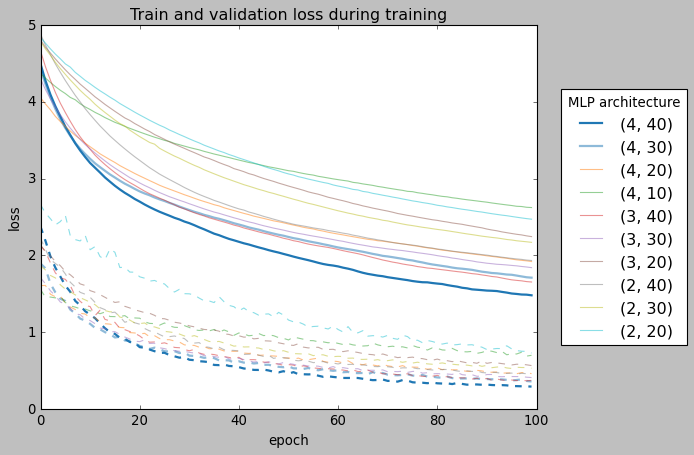

In [144]:
import matplotlib as mpl
from matplotlib import pyplot as plt

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(capacity_results[0].keys())))

for i, (k, v) in enumerate(capacity_results[1].items()):
    if k not in ks: continue
    plt.plot(v, ls='-', label=str(k), c=c[i],
             linewidth=2 if i <= 1 else 1, alpha=.5 if i > 0 else 1)

for i, (k, v) in enumerate(capacity_results[0].items()):
    if k not in ks: continue
    plt.plot(v, ls='--', c=c[i],
             linewidth=2 if i <= 1 else 1, alpha=.5 if i > 0 else 1)

plt.title("Train and validation loss during training")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, title='MLP architecture')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("experiments/capacity loss.pdf", bbox_inches='tight', )

In [145]:
run_ids_map = {}
for size in runs_df['params.train_size'].unique():
    run_ids_map[size] = runs_df[runs_df['params.train_size'] == size]['run_id'].to_list()
run_ids_map['19999'] += run_ids_map['19998']
run_ids_map['5318'] += run_ids_map['5318']
run_ids_map['1414'] += run_ids_map['1413']
del run_ids_map['19998'], run_ids_map['5318'], run_ids_map['1413']

In [146]:
ds_size_results = summarize(run_ids_map)

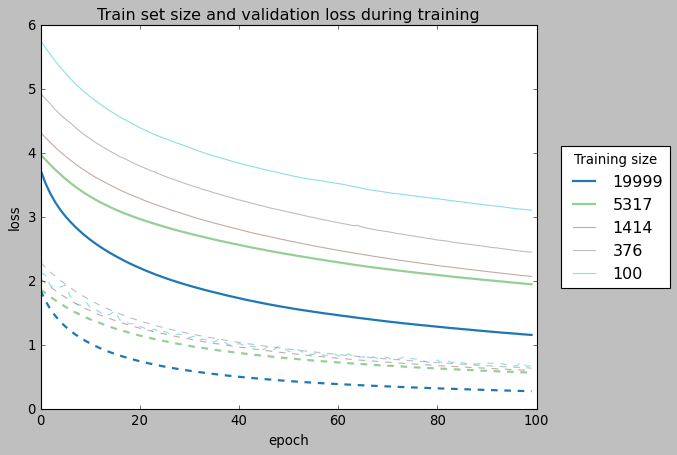

In [147]:
import matplotlib as mpl
from matplotlib import pyplot as plt

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, len(ds_size_results[0].keys())))

for i, (k, v) in enumerate(ds_size_results[1].items()):
    plt.plot(v, ls='-', label=str(k), c=c[i],
             linewidth=2 if i <= 1 else 1, alpha=.5 if i > 0 else 1)

for i, (k, v) in enumerate(ds_size_results[0].items()):
    plt.plot(v, ls='--', c=c[i],
             linewidth=2 if i <= 1 else 1, alpha=.5 if i > 0 else 1)

plt.title("Train set size and validation loss during training")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, title='Training size')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("experiments/train size.pdf", bbox_inches='tight', )

In [ ]:
runs_df = runs_df[runs_df['tags.health'].isnull()]
all_run_names = runs_df["tags.mlflow.runName"].dropna().tolist()

In [6]:
_train_ds = SeismicTwoStoriesTrussDatasetSingleTarget("./data/dataset/seismic_two_stories/train/data.hdf5",
                                                      noise_loads=lambda size: np.random.normal(1, 0.01, size=size),
                                                      noise_strain=lambda size: np.random.normal(1, 0.01, size=size),
                                                      noise_displacement=lambda size: np.random.normal(0, 2.5e-4,
                                                                                                       size=size))

_test_ds = SeismicTwoStoriesTrussDatasetSingleTarget("./data/dataset/seismic_two_stories/test/data.hdf5",
                                                     noise_loads=lambda size: np.random.normal(1, 0.01, size=size),
                                                     noise_strain=lambda size: np.random.normal(1, 0.0, size=size),
                                                     noise_displacement=lambda size: np.random.normal(0, 2.5e-4,
                                                                                                      size=size))

in_dim = _train_ds[0][0].__len__()
out_dim = _train_ds[0][1].__len__()

In [11]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("final_model")

sizes = np.linspace(5_000, 20_000, 4, dtype=int)
activations = [nn.ReLU, nn.Tanh]
n_neurons_values = [30, 35, 40]
n_layers_values = [3, 4, 5]

with ThreadPoolExecutor(max_workers=5) as executor:
    thread_pool = []
    for size in sizes:
        batch_size = min(2048, 2 ** int(np.floor(np.log2(size)) - 1))

        np.random.seed(RANDOM_STATE + size)
        ds = Subset(_train_ds, np.random.choice(np.arange(len(_train_ds)), size, replace=False))

        for activation in activations:
            for n_neurons in n_neurons_values:
                for n_layers in n_layers_values:
                    thread = executor.submit(routine,
                                             run_name=None,
                                             train_ds=ds, val_ds=_test_ds,
                                             n_neurons=n_neurons, n_layers=n_layers,
                                             activation=activation, activation_params=None,
                                             n_epoch=500, train_batch_size=batch_size, val_batch_size=len(_test_ds))

                    thread_pool.append(thread)

    for thread in thread_pool: thread.result()


Start thread 14082863104Start thread 14217605120

Start thread 14234431488
Start thread 14251257856
Start thread 14268084224
🏃 View run charming-grub-411 at: http://127.0.0.1:5000/#/experiments/189734136132377816/runs/8ef558856c3748108f007b21314aaa17
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/189734136132377816
Start thread 14251257856
🏃 View run stylish-gnu-923 at: http://127.0.0.1:5000/#/experiments/189734136132377816/runs/12a90086924d4cf59fd37acff0b9830c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/189734136132377816
Start thread 14082863104
🏃 View run trusting-crane-748 at: http://127.0.0.1:5000/#/experiments/189734136132377816/runs/fabefe9f5ea1499a9fe14c3cb3a2408e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/189734136132377816
Start thread 14217605120
🏃 View run treasured-perch-932 at: http://127.0.0.1:5000/#/experiments/189734136132377816/runs/97a00c837cf54e18a09deacdbe6ae7c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/189734

In [23]:

def train_with_PINN(model, train_ds, val_ds, lr, n_epochs, train_batch_size, verbose=True, verbose_step=50,
                    val_batch_size=None):
    model = model.to(device)
    if val_batch_size is None:
        val_batch_size = train_batch_size
    train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=val_batch_size, shuffle=True)

    elems = torch.tensor([[0, 1], [1, 2], [3, 4], [4, 5], [1, 4], [2, 5], [0, 4], [3, 1], [1, 5], [4, 2]]).to(device)
    supports = torch.tensor([0, 1, 6, 7]).to(device)

    # Fit scalers
    x_scaler = StandardScaler(in_dim).to(device)
    y_scaler = StandardScaler(out_dim).to(device)
    for data, target, _, _, _ in train_dl:
        x_scaler.partial_fit(data.to(device))
        y_scaler.partial_fit(target.to(device))

    # Train
    data_criterion = nn.MSELoss()
    physics_criterion = StiffnessToLoadLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    MSE = nn.MSELoss()
    R2 = R.R2Score().to(device)
    MAPE = R.MeanAbsolutePercentageError().to(device)

    best_val_loss = np.inf
    best_model = None

    physics_loss_list = []
    physics_loss_scale = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loss_epoch = []
        train_data_loss_epoch = []
        train_physics_loss_epoch = []
        train_MSE_epoch = []
        train_MAPE_epoch = []
        train_R2_epoch = []

        for batch in train_dl:
            data, target, nodes, u, q = batch
            data, target = data.to(device), target.to(device)
            nodes, u, q = nodes.to(device), u.to(device), q.to(device)

            # Normalize
            z_data = x_scaler.transform(data)
            z_target = y_scaler.transform(target)

            # Train
            optimizer.zero_grad()
            z_target_pred = model(z_data)
            target_pred = y_scaler.inverse_transform(z_target_pred)

            stiffness_pred = construct_k_from_ea(target_pred, nodes, elems, supports, device=device)

            data_loss = data_criterion(z_target_pred, z_target)
            physics_loss = physics_criterion(stiffness_pred, u, q)

            if epoch == 0:
                physics_loss_list.append(physics_loss.item())
                physics_loss_scale = torch.tensor(physics_loss_list, device=device).mean().item()

            physics_loss /= physics_loss_scale

            loss = data_loss + physics_loss
            loss.backward()
            optimizer.step()

            # Metrics

            train_loss_epoch.append(loss.item())
            train_data_loss_epoch.append(data_loss.item())
            train_physics_loss_epoch.append(physics_loss.item())
            train_MSE_epoch.append(MSE(target_pred, target).item())
            train_MAPE_epoch.append(MAPE(target_pred, target).item())
            train_R2_epoch.append(R2(target_pred, target))

        model.eval()
        with torch.no_grad():
            val_loss_epoch = []
            val_data_loss_epoch = []
            val_physics_loss_epoch = []
            val_MSE_epoch = []
            val_MAPE_epoch = []
            val_R2_epoch = []
            for batch in val_dl:
                data, target, nodes, u, q = batch
                data, target = data.to(device), target.to(device)
                nodes, u, q = nodes.to(device), u.to(device), q.to(device)

                # Normalize
                z_data = x_scaler.transform(data)
                z_target = y_scaler.transform(target)

                # Metrics
                z_target_pred = model(z_data)
                target_pred = y_scaler.inverse_transform(z_target_pred)

                stiffness_pred = construct_k_from_ea(target_pred, nodes, elems, supports, device=device)

                data_loss = data_criterion(z_target_pred, z_target)
                physics_loss = physics_criterion(stiffness_pred, u, q)

                physics_loss /= physics_loss_scale

                loss = data_loss + physics_loss

                val_loss_epoch.append(loss.item())
                val_data_loss_epoch.append(data_loss.item())
                val_physics_loss_epoch.append(physics_loss.item())
                val_MSE_epoch.append(MSE(target_pred, target).item())
                val_MAPE_epoch.append(MAPE(target_pred, target).item())
                val_R2_epoch.append(R2(target_pred, target))

            train_loss = torch.tensor(train_loss_epoch, device=device).mean().item()
            train_data_loss = torch.tensor(train_data_loss_epoch, device=device).mean().item()
            train_physics_loss = torch.tensor(train_physics_loss_epoch, device=device).mean().item()
            train_MSE = torch.tensor(train_MSE_epoch, device=device).mean().item()
            train_MAPE = torch.tensor(train_MAPE_epoch, device=device).mean().item()
            train_R2 = torch.tensor(train_R2_epoch, device=device).mean().item()

            val_loss = torch.tensor(val_loss_epoch, device=device).mean().item()
            val_data_loss = torch.tensor(val_data_loss_epoch, device=device).mean().item()
            val_physics_loss = torch.tensor(val_physics_loss_epoch, device=device).mean().item()
            val_MSE = torch.tensor(val_MSE_epoch, device=device).mean().item()
            val_MAPE = torch.tensor(val_MAPE_epoch, device=device).mean().item()
            val_R2 = torch.tensor(val_R2_epoch, device=device).mean().item()

        # Logging
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_data_loss": train_data_loss,
            "train_physics_loss": train_physics_loss,
            "train_mse": train_MSE,
            "train_mape": train_MAPE,
            "train_r2": train_R2,

            "val_loss": val_loss,
            "val_data_loss": val_data_loss,
            "val_physics_loss": val_physics_loss,
            "val_mse": val_MSE,
            "val_mape": val_MAPE,
            "val_r2": val_R2,
        }, step=epoch)

        if verbose and (epoch + 1) % verbose_step == 0:
            print(f"[Epoch] {epoch + 1:{len(str(n_epochs))}d}/{n_epochs:d}", end='  ')
            print(f"TRAIN", end='   ')
            print(f"Loss: {train_loss:1.4f}", end='   ')
            print(f"Data L.: {train_data_loss:1.4f}", end='   ')
            print(f"Phys L.: {train_physics_loss:1.4f}", end='   ')
            print(f"MSE: {train_MSE:1.4e}", end='   ')
            print(f"MAPE: {train_MAPE:1.4f}", end='   ')
            print(f"R2: {train_R2: 1.4f}", end='   ')
            print("  ||  ", end='')
            print(f"VALIDATION", end='   ')
            print(f"Loss: {val_loss:1.4f}", end='   ')
            print(f"Data L.: {val_data_loss:1.4f}", end='   ')
            print(f"Phys L.: {val_physics_loss:1.4f}", end='   ')
            print(f"MSE: {val_MSE:1.4e}", end='   ')
            print(f"MAPE: {val_MAPE:1.4f}", end='   ')
            print(f"R2: {val_R2: 1.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)

    signature = mlflow.models.infer_signature(z_data.cpu().detach().numpy(), z_target_pred.cpu().detach().numpy())

    # Log all models
    mlflow.pytorch.log_model(
        pytorch_model=best_model,
        input_example=z_data.cpu().detach().numpy(),
        artifact_path='model',
        signature=signature,
    )

    signature = mlflow.models.infer_signature(data.cpu().detach().numpy(), z_data.cpu().detach().numpy())
    mlflow.pytorch.log_model(
        pytorch_model=x_scaler,
        artifact_path='x_scaler',
        signature=signature,
    )

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(), z_target.cpu().detach().numpy())
    mlflow.pytorch.log_model(
        pytorch_model=y_scaler,
        artifact_path='y_scaler',
        signature=signature,
    )

In [25]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("final_model_pinn_one_epoch_scale")

sizes = np.linspace(5_000, 20_000, 4, dtype=int)
activations = [nn.ReLU, nn.Tanh]
n_neurons_values = [30, 35, 40]
n_layers_values = [3, 4, 5]

with ThreadPoolExecutor(max_workers=5) as executor:
    thread_pool = []
    for size in sizes:
        batch_size = min(2048, 2 ** int(np.floor(np.log2(size)) - 1))

        np.random.seed(RANDOM_STATE + size)
        ds = Subset(_train_ds, np.random.choice(np.arange(len(_train_ds)), size, replace=False))

        for activation in activations:
            for n_neurons in n_neurons_values:
                for n_layers in n_layers_values:
                    thread = executor.submit(routine,
                                             run_name=None, train_routine=train_with_PINN,
                                             train_ds=ds, val_ds=_test_ds,
                                             n_neurons=n_neurons, n_layers=n_layers,
                                             activation=activation, activation_params=None,
                                             n_epoch=500, train_batch_size=batch_size, val_batch_size=len(_test_ds))

                    thread_pool.append(thread)

    for thread in thread_pool: thread.result()


2025/02/27 08:40:53 INFO mlflow.tracking.fluent: Experiment with name 'final_model_pinn_one_epoch_scale' does not exist. Creating a new experiment.


Start thread 15602839552Start thread 15703502848

Start thread 15728717824
Start thread 15745544192
Start thread 15762370560
🏃 View run legendary-robin-5 at: http://127.0.0.1:5000/#/experiments/719691356235619709/runs/c3d7dbe1cbba4b9cab78574c0726c471
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/719691356235619709
Start thread 15728717824
🏃 View run resilient-hare-736 at: http://127.0.0.1:5000/#/experiments/719691356235619709/runs/f07bbcb4f32a4df88ba1068199788a12
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/719691356235619709
Start thread 15703502848
🏃 View run abrasive-moose-621 at: http://127.0.0.1:5000/#/experiments/719691356235619709/runs/89703761d95f48b3b19f56f5e9b28705
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/719691356235619709
Start thread 15762370560
🏃 View run thoughtful-calf-297 at: http://127.0.0.1:5000/#/experiments/719691356235619709/runs/281f907d1bf241f39432737bcd19c839
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/719

In [91]:
def summarize(run_ids_map):
    train_losses = {}
    val_losses = {}
    train_MSE = {}
    val_MSE = {}
    train_MAPE = {}
    val_MAPE = {}
    train_R2 = {}
    val_R2 = {}
    for key, run_ids in run_ids_map.items():
        train_losses[key] = []
        val_losses[key] = []
        train_MSE[key] = []
        val_MSE[key] = []
        train_MAPE[key] = []
        val_MAPE[key] = []
        train_R2[key] = []
        val_R2[key] = []
        for run_id in run_ids:
            client = mlflow.tracking.MlflowClient()

            # Get metric history
            train_loss_hist = client.get_metric_history(run_id, "train_loss")
            val_loss_hist = client.get_metric_history(run_id, "val_loss")
            train_MSE_hist = client.get_metric_history(run_id, "train_mse")
            val_MSE_hist = client.get_metric_history(run_id, "val_mse")
            train_MAPE_hist = client.get_metric_history(run_id, "train_mape")
            val_MAPE_hist = client.get_metric_history(run_id, "val_mape")
            train_R2_hist = client.get_metric_history(run_id, "train_r2")
            val_R2_hist = client.get_metric_history(run_id, "val_r2")

            # Convert to lists of loss values per epoch
            train_losses[key].append([m.value for m in train_loss_hist])
            val_losses[key].append([m.value for m in val_loss_hist])

            train_MSE[key].append([m.value for m in train_MSE_hist])
            val_MSE[key].append([m.value for m in val_MSE_hist])

            train_MAPE[key].append([m.value for m in train_MAPE_hist])
            val_MAPE[key].append([m.value for m in val_MAPE_hist])

            train_R2[key].append([m.value for m in train_R2_hist])
            val_R2[key].append([m.value for m in val_R2_hist])

        train_losses[key] = np.vstack(train_losses[key]).mean(axis=0)
        val_losses[key] = np.vstack(val_losses[key]).mean(axis=0)
        train_MSE[key] = np.vstack(train_MSE[key]).mean(axis=0)
        val_MSE[key] = np.vstack(val_MSE[key]).mean(axis=0)
        train_MAPE[key] = np.vstack(train_MAPE[key]).mean(axis=0)
        val_MAPE[key] = np.vstack(val_MAPE[key]).mean(axis=0)
        train_R2[key] = np.vstack(train_R2[key]).mean(axis=0)
        val_R2[key] = np.vstack(val_R2[key]).mean(axis=0)
    return (train_losses,
            val_losses,
            train_MSE,
            val_MSE,
            train_MAPE,
            val_MAPE,
            train_R2,
            val_R2,)

In [148]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
experiment = mlflow.get_experiment_by_name("final_model")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [149]:
best_df = runs_df[runs_df['metrics.val_mape'] == runs_df['metrics.val_mape'].min()]

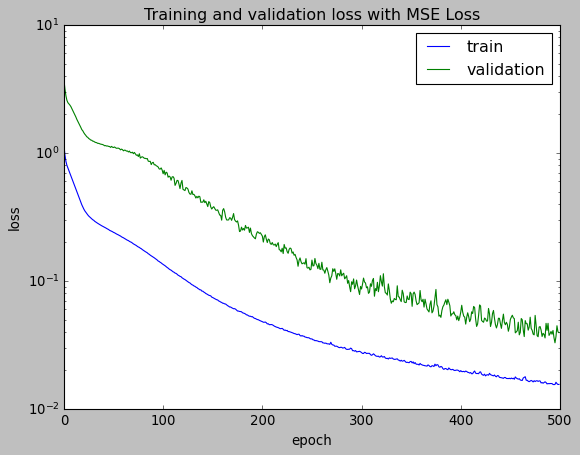

In [150]:
run_id = best_df['run_id'].iloc[0]
client = mlflow.tracking.MlflowClient()

# Get metric history
train_loss_hist = client.get_metric_history(run_id, "train_loss")
train_loss_hist = [m.value for m in train_loss_hist]
val_loss_hist = client.get_metric_history(run_id, "val_loss")
val_loss_hist = [m.value for m in val_loss_hist]

plt.plot(np.arange(len(train_loss_hist)), train_loss_hist, label="train")
plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, label="validation")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Training and validation loss with MSE Loss")
plt.legend()
plt.savefig("experiments/model_regular_loss.pdf", bbox_inches='tight', )

In [151]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
experiment = mlflow.get_experiment_by_name("final_model_pinn_one_epoch_scale")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [152]:
best_df = runs_df[runs_df['metrics.val_mape'] == runs_df['metrics.val_mape'].min()]

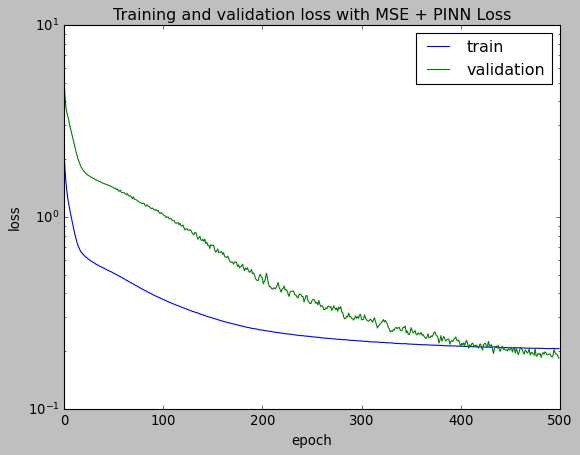

In [153]:
run_id = best_df['run_id'].iloc[0]
client = mlflow.tracking.MlflowClient()

# Get metric history
train_loss_hist = client.get_metric_history(run_id, "train_loss")
train_loss_hist = [m.value for m in train_loss_hist]
val_loss_hist = client.get_metric_history(run_id, "val_loss")
val_loss_hist = [m.value for m in val_loss_hist]

plt.plot(np.arange(len(train_loss_hist)), train_loss_hist, label="train")
plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, label="validation")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Training and validation loss with MSE + PINN Loss")
plt.legend()
plt.savefig("experiments/model_pinn_loss.pdf", bbox_inches='tight', )

In [154]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
experiment = mlflow.get_experiment_by_name("final_model")
runs_df_data = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
experiment = mlflow.get_experiment_by_name("final_model_pinn_one_epoch_scale")
runs_df_pinn = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [160]:
# gather data
sizes = runs_df_data['params.train_size'].unique()

run_ids_map = {}
for size in sizes:
    run_ids_map[size] = runs_df_data[runs_df_data['params.train_size'] == size]['run_id'].to_list()

val_mape_data_hist = {}
for size, ids in run_ids_map.items():
    best = np.inf
    for run_id in ids:
        val_mape_hist = client.get_metric_history(run_id, "val_mape")
        val_mape_hist = [m.value for m in val_mape_hist]
        if np.min(val_mape_hist) < best:
            best = np.min(val_mape_hist)
            val_mape_data_hist[size] = val_mape_hist

run_ids_map = {}
for size in sizes:
    run_ids_map[size] = runs_df_pinn[runs_df_data['params.train_size'] == size]['run_id'].to_list()

val_mape_pinn_hist = {}
for size, ids in run_ids_map.items():
    best = np.inf
    for run_id in ids:
        val_mape_hist = client.get_metric_history(run_id, "val_mape")
        val_mape_hist = [m.value for m in val_mape_hist]
        if np.min(val_mape_hist) < best:
            best = np.min(val_mape_hist)
            val_mape_pinn_hist[size] = val_mape_hist

In [161]:
# process data
for k in val_mape_data_hist.keys():
    hist = val_mape_data_hist[k]
    best = np.inf
    for i, v in enumerate(hist):
        if v < best:
            best = v
        hist[i] = best
    val_mape_data_hist[k] = hist

for k in val_mape_pinn_hist.keys():
    hist = val_mape_pinn_hist[k]
    best = np.inf
    for i, v in enumerate(hist):
        if v < best:
            best = v
        hist[i] = best
    val_mape_pinn_hist[k] = hist


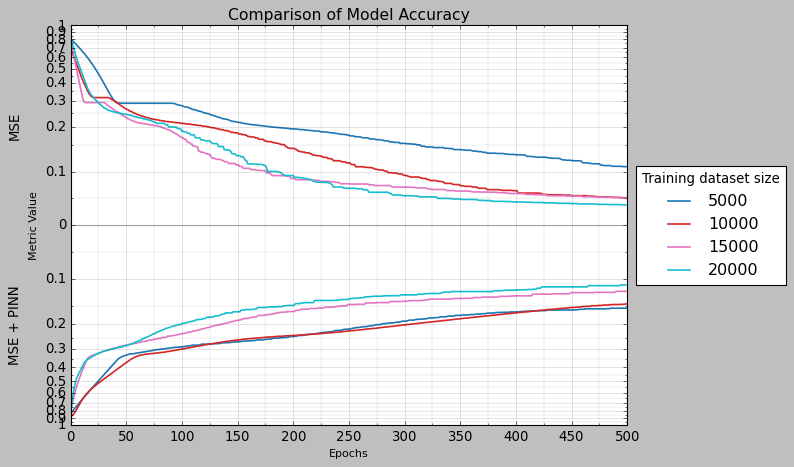

In [216]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create color gradients from light blue to dark blue
n_sizes = len(val_mape_data_hist)
cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, len(sizes)))

# Sort the sizes for consistent coloring
sizes = sorted(val_mape_data_hist.keys(), key=lambda x:int(x))

# Plot upper curves with color gradient
for i, size in enumerate(sizes):
    metrics = val_mape_data_hist[size]
    ax.plot(np.arange(len(metrics)), metrics, color=colors[i], linewidth=1.5, label=f"{size}")

# Plot lower curves with same color gradient
for i, size in enumerate(sizes):
    metrics = val_mape_pinn_hist[size]
    ax.plot(np.arange(len(metrics)), -np.array(metrics), color=colors[i], linewidth=1.5, linestyle='-')

# Add horizontal line at y=0 to separate the two curves
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Set labels and title
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('Metric Value', fontsize=10)
ax.set_title('Comparison of Model Accuracy', fontsize=14)

# Set y-axis to symmetric log scale
ax.set_yscale('symlog', linthresh=0.15, linscale=0.5)

# Custom formatter for the y-ticks to show absolute values
def custom_formatter(x, pos):
    if x > 0:
        return f"{x:.2g}"
    elif x < 0:
        return f"{-x:.2g}"
    else:
        return "0"

import matplotlib.ticker as ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))

ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.yaxis.set_minor_locator(MultipleLocator(.05))


# Enable both major and minor grids
ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.3)
ax.grid(True, which="minor", linestyle=":", linewidth=0.3, alpha=0.2)

# Add a legend at center right outside the plot
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), title="Training dataset size")

# Create two separate y-axis labels for clarity
ax.text(-.1, .75, 'MSE', rotation=90, va='center', ha='center', transform=ax.transAxes)
ax.text(-.1, .25, 'MSE + PINN', rotation=90, va='center', ha='center', transform=ax.transAxes)

ax.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.subplots_adjust(right=0.8)  # Make room for the legend

plt.savefig("experiments/data_vs_pinn_accuracy over time.pdf", bbox_inches='tight', )